# Stream-mode active learning example

In this example, we demonstrate how to use PyePAL for continous, stream-mode active learning (AL) with batch sampling. This is particularly useful if the design space can be augmented after performing a single or a few active learning iterations and a user would like to sampling several design points in parallel during each iteration cycle. To obtain our experimental design, we will use the open-source package [doepy](https://github.com/tirthajyoti/doepy). If you do not have the package installed, we recommend executing the following cell or running the command locally. Please note that doepy is built on top of [pyDOE](https://pythonhosted.org/pyDOE/) and has a couple of additional dependencies. We will use the space-filling Latin Hypercube Sampling (LHS) design in order to generate samples for our design space during each active learning cycle. 


Our stream-mode active learning workflow goes as follows:

    1. First start out with 100 design points with space-filling LHS sampling
    2. Run the first PAL cycle and sample 5 points  batchwise suggested by PyePAL
    3. Generate 20 new design points in the subsequent PAL cycle and again sample 5 points batchwise provided these additional design points
    4. Repeat step 3 until we either reach a point where we do not predict any more epsilon-pareto optimal points or finish 10 AL cycles

Execute the following cell if you do not have doepy installed on your machine

In [ ]:
!pip install doepy

## Problem scope

### input variables

Our input variables will be defined as follows:

- $x_1 \in (0, 1)$: Compound A ranging from 0 to 1 (wt. fraction)

- $x_2 \in (0, 1)$: Compound B ranging from 0 to 1 where $x_2 = 1-x_1$ (wt. fraction)

- $x_3 \in (273,373)$: Temperature ranging from 273 to 373 Kelvin

- $x_4 \in (1, 100)$: Pressure ranging from 1 to 100 bar


Note that $x_1$ is a function of $x_2$ and are constrained by their sum equalling 1. Since most open-source, experimental design packages do not account for constraints, we will use a simple trick when performing our DoE; we will exclude $x_2$ from the DoE, then add it back into our design matrix. We can get away with this since we only have 2 variables with the single constraint. We would not be able to apply this same trick if there were more compounds in our system.

Here, we will use doepy to generate some samples:

In [1]:
from doepy import build
import numpy as np

def generate_design(num_samples, seed=None):
    np.random.seed(seed)

    # doepy will generate the design matrix as a pandas dataframe
    # here we fix the design limits based on the description above
    X = build.space_filling_lhs(
    {'Compound_A':[0,1],
    'Temperature_K':[273,373], 
    'Pressure_bar':[1,100]},
    num_samples = num_samples
    )

    # add compound B to design matrix
    X['Compound_B'] = 1-X['Compound_A']

    # reorder columns to follow equations
    X = X[['Compound_A','Compound_B', 'Temperature_K', 'Pressure_bar']]
    return X

initial_design = generate_design(100,0)
initial_design

,Compound_A,Compound_B,Temperature_K,Pressure_bar
0,0.262626,0.737374,291.181818,43.0
1,0.868687,0.131313,302.292929,97.0
2,0.020202,0.979798,337.646465,59.0
3,0.555556,0.444444,365.929293,15.0
4,0.757576,0.242424,345.727273,73.0
...,...,...,...,...
95,0.969697,0.030303,315.424242,4.0
96,0.676768,0.323232,276.030303,83.0
97,0.646465,0.353535,366.939394,68.0
98,0.474747,0.525253,321.484848,25.0


### objectives

For demonstration purposes, we will assume we have 3 objectives that we want to optimize, all of which are arbitrary functions of the input variables described above. For sake of simplicity, one of those objectives will be sampled using a multiple linear regression model with random Gaussian noise and pre-defined weight coefficients as follows:

$$ 
Y_{0i} = \beta_{0} + \beta_{1}x_{i1} + \beta_{2}x_{i2} + \beta_{3}x_{i3} + \beta_{4}x_{i4} + \epsilon \ \ (1) $$


the second objective will have the following dependence on $x_{i1}$ and $x_{i2}$:

$$ 
Y_{1i} = \tilde{\beta_{1}}x_{i1} + \tilde{\beta_{2}}x_{i2} + \tilde{\beta_{3}}x_{i1}x_{i2} + \epsilon \ \ (2)
$$


and finally, the third objective will be a function of $x_{i4}$ only:

$$ 
Y_{2i} = log(x_{i4}) + \epsilon \ \ (3)
$$


where $\epsilon \sim N(0, \sigma^2).$


In [2]:
def obj0(beta, X, sigma=1, seed = None):
    beta = beta.reshape(-1,1)
    beta_dim, _ = beta.shape
    n, X_dim = X.shape
    assert beta_dim == (X_dim+1)
    
    # add ones columns for intercept (Beta0's)
    X = np.hstack((np.atleast_2d(np.ones(n)).T, X))
    
    np.random.seed(seed)
    return np.matmul(X, beta) + np.random.normal(0, sigma,n).reshape(-1,1)

def obj1(beta, X, sigma=1, seed = None):
    assert len(beta)==3
    n = len(X)
    np.random.seed(seed)
    return beta[0]*X[:,0] + beta[1]*X[:,1] + beta[2]*X[:,0]* X[:,1] + np.random.normal(0, sigma,n)

def obj2(X, sigma=1, seed = None):
    n = len(X)
    np.random.seed(seed)
    return np.log(X[:,3]) + np.random.normal(0, sigma,n)

In [3]:
# define weight coefficients
beta = np.array([-0.5, 0.4, 0.5, 0.001, -0.01])
beta_hat = np.array([0.5, -0.2, 2])

# obtain true response from the initial design
Y1 = obj0(beta, initial_design.to_numpy()).reshape(-1,1)
Y2 = obj1(beta_hat, initial_design.to_numpy()).reshape(-1,1)
Y3 = obj2(initial_design.to_numpy()).reshape(-1,1)


### (optional) visualize our true pareto front 

In [4]:
def get_pareto_optimal(response):
    """
    Find the pareto optimal points
    """
    optimal = np.ones(response.shape[0], dtype = bool)
    for i, c in enumerate(response):
        if optimal[i]:
            optimal[optimal] = np.any(response[optimal]>c, axis=1)  
            optimal[i] = True  
    return optimal

In [5]:
response = np.hstack(np.array([Y1,Y2,Y3]))
optimal_ix = get_pareto_optimal(response)

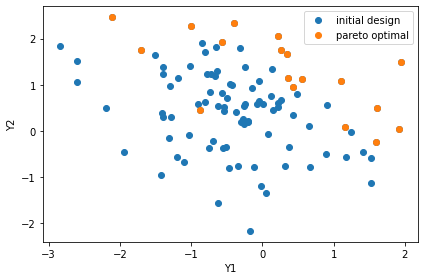

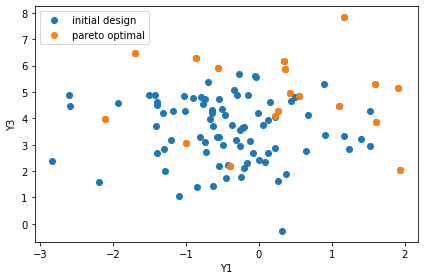

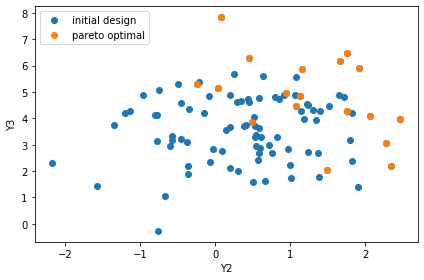

In [6]:
import matplotlib.pylab as plt
# from pyepal.plotting import plot_pareto_front_2d

plt.figure()
plt.plot(Y1,Y2,'o', label='initial design')
plt.plot(Y1[optimal_ix], Y2[optimal_ix],'o', label='pareto optimal')
plt.xlabel('Y1')
plt.ylabel('Y2')
plt.legend()
plt.tight_layout()

plt.figure()
plt.plot(Y1,Y3,'o', label='initial design')
plt.plot(Y1[optimal_ix], Y3[optimal_ix],'o', label='pareto optimal')
plt.xlabel('Y1')
plt.ylabel('Y3')
plt.legend()
plt.tight_layout()

plt.figure()
plt.plot(Y2,Y3,'o', label='initial design')
plt.plot(Y2[optimal_ix], Y3[optimal_ix],'o', label='pareto optimal')
plt.xlabel('Y2')
plt.ylabel('Y3')
plt.legend()
plt.tight_layout()

plt.show()

## Run first PyePAL iteration with sklearn_instance

In [ ]:
# TODO: run 1 iteration of PyePAL with batch-mode sampling

## Generate new design points

In [7]:
# set a seed so that we obtain the same results every execution of this cell
np.random.seed(0)
num_cycles = 10

for cycle in range(num_cycles):
    # generate the new design matrix
    X_new = generate_design(20, seed=None)
    print(X_new)
    
    # TODO: run PyePAL with batch mode sampling and add new design matrix using augment_design_space function in PyePAL
    
    
    

    Compound_A  Compound_B  Temperature_K  Pressure_bar
0     0.000000    1.000000     315.105263    100.000000
1     1.000000    0.000000     299.315789     79.157895
2     0.052632    0.947368     309.842105     37.473684
3     0.736842    0.263158     273.000000     84.368421
4     0.315789    0.684211     325.631579     47.894737
5     0.421053    0.578947     304.578947     94.789474
6     0.789474    0.210526     362.473684      1.000000
7     0.263158    0.736842     294.052632     16.631579
8     0.105263    0.894737     278.263158     68.736842
9     0.473684    0.526316     367.736842     32.263158
10    0.368421    0.631579     320.368421     21.842105
11    0.947368    0.052632     283.526316      6.210526
12    0.631579    0.368421     351.947368     73.947368
13    0.578947    0.421053     341.421053     11.421053
14    0.157895    0.842105     346.684211     53.105263
15    0.684211    0.315789     288.789474     42.684211
16    0.210526    0.789474     357.210526     58